# INTRODUCTION

## Contexte du Projet

## Mise en place de PySpark

In [27]:
# Installation de pyspark
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


IMPORTANT : PENSEZ A INSTALLER JAVA - winget install --exact --id EclipseAdoptium.Temurin.11.JDK

Fix pour python 3.12 qui ne contient plus la librairie distutils

In [28]:
import sys
try:
    import distutils
except ModuleNotFoundError:
    import setuptools._distutils as distutils
    sys.modules["distutils"] = distutils

In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MoviesRatings") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()


## Import et traitement des datasets

In [30]:
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display
from pyspark.sql.functions import isnan, when, count, col, avg, lit, explode, split, row_number
from pyspark.sql.window import Window
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import collect_list

In [31]:
# Import des datasets ratings.csv & movies.csv
ratings = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)


In [32]:
# On Affiche les les 10 premières lignes des deux datasets
ratings.show(10)
movies.show(10)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
+------+-------+------+---------+
only showing top 10 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|

In [33]:
# On affiche le schéma des deux datasets
ratings.printSchema()
movies.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [34]:
# On regarde le nombre de lignes de chaque dataset
print("Nombre de lignes dans ratings : ", ratings.count())
print("Nombre de lignes dans movies : ", movies.count())

Nombre de lignes dans ratings :  100836
Nombre de lignes dans movies :  9742


### Imports PySpark

In [35]:
from pyspark.sql.functions import isnan, when, count, col, avg, lit, explode, split, row_number
from pyspark.sql.window import Window

In [36]:
# On regarde le nombre de valeurs manquantes dans chaque dataset

ratings.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ratings.columns]).show()
movies.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in movies.columns]).show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+



In [37]:
# On regarde le nombre de valeurs distinctes dans chaque dataset
ratings.agg(*(count(col(c)).alias(c) for c in ratings.columns)).show()
movies.agg(*(count(col(c)).alias(c) for c in movies.columns)).show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|100836| 100836|100836|   100836|
+------+-------+------+---------+

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|   9742| 9742|  9742|
+-------+-----+------+



In [38]:
# On regarde les statistiques descriptives des colonnes rating et timestamp du dataset ratings
ratings.describe(["rating", "timestamp"]).show()


+-------+------------------+--------------------+
|summary|            rating|           timestamp|
+-------+------------------+--------------------+
|  count|            100836|              100836|
|   mean| 3.501556983616962|1.2059460873684695E9|
| stddev|1.0425292390606342|2.1626103599513078E8|
|    min|               0.5|           828124615|
|    max|               5.0|          1537799250|
+-------+------------------+--------------------+



In [39]:
# Quels sont les films les mieux notés en moyenne 

ratings.groupBy("movieId").agg(avg("rating").alias("avg_rating")).orderBy("avg_rating", ascending=False).show()

+-------+----------+
|movieId|avg_rating|
+-------+----------+
|  26350|       5.0|
|   3795|       5.0|
|  25887|       5.0|
| 157775|       5.0|
|    633|       5.0|
|  33138|       5.0|
|  67618|       5.0|
|    876|       5.0|
|    496|       5.0|
|  27373|       5.0|
| 113829|       5.0|
|  53578|       5.0|
| 152711|       5.0|
| 118894|       5.0|
|     53|       5.0|
| 160644|       5.0|
|    148|       5.0|
|   8911|       5.0|
| 147300|       5.0|
|  84273|       5.0|
+-------+----------+
only showing top 20 rows



In [40]:
# Quels sont les films les plus populaires 
ratings.groupBy("movieId").count().orderBy("count", ascending=False).show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|     50|  204|
|   2858|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



In [41]:
# Quels sont les 10 films les mieux notés en moyenne avec plus de 100/200 & 300 notes

# Jointure commune entre ratings et movies
ratings_with_titles = ratings.join(movies, on="movieId", how="inner")

# Fonction pour obtenir les films mieux notés avec un seuil minimal de votes
def top_movies_by_avg(threshold, limit=10):
    return (
        ratings_with_titles
        .groupBy("movieId", "title")
        .agg(avg("rating").alias("avg_rating"), count("rating").alias("count_rating"))
        .filter(col("count_rating") > threshold)
        .orderBy(col("avg_rating").desc())
        .select("title", "avg_rating", "count_rating")
        .limit(limit)
    )

top_movies_by_avg(100).show(10, False)
top_movies_by_avg(200).show(10, False)
top_movies_by_avg(300).show(10, False)

+-----------------------------------------+-----------------+------------+
|title                                    |avg_rating       |count_rating|
+-----------------------------------------+-----------------+------------+
|Shawshank Redemption, The (1994)         |4.429022082018927|317         |
|Godfather, The (1972)                    |4.2890625        |192         |
|Fight Club (1999)                        |4.272935779816514|218         |
|Godfather: Part II, The (1974)           |4.25968992248062 |129         |
|Departed, The (2006)                     |4.252336448598131|107         |
|Goodfellas (1990)                        |4.25             |126         |
|Dark Knight, The (2008)                  |4.238255033557047|149         |
|Usual Suspects, The (1995)               |4.237745098039215|204         |
|Princess Bride, The (1987)               |4.232394366197183|142         |
|Star Wars: Episode IV - A New Hope (1977)|4.231075697211155|251         |
+------------------------

In [42]:
# Quels genres de films sont les plus populaires ? (nb de notes) & Top 5 des films les plus populaires par genre

def most_popular_movies(limit=30):
    return (
        ratings.groupBy("movieId")
               .agg(count("rating").alias("count_rating"))
               .join(movies, "movieId")
               .orderBy(col("count_rating").desc())
               .limit(limit)
    )

def top5_by_genre():
    movies_with_genre = movies.withColumn("genre", explode(split(col("genres"), "\\|")))
    movies_ratings = ratings.join(movies_with_genre, "movieId")
    movies_stats = movies_ratings.groupBy("title", "genre") \
        .agg(count("rating").alias("count_rating"), avg("rating").alias("avg_rating"))
    windowSpec = Window.partitionBy("genre").orderBy(col("count_rating").desc())
    return movies_stats.withColumn("rank", row_number().over(windowSpec)) \
        .filter(col("rank") <= 5) \
        .orderBy("genre", "rank")

def display_top5_by_genre(limit_per_genre=5):
    df = top5_by_genre()
    # Récupérer la liste des genres distincts
    genres = [row["genre"] for row in df.select("genre").distinct().collect()]
    for genre in sorted(genres):
        print(f"Genre: {genre}")
        df.filter(col("genre") == genre).orderBy("rank").show(limit_per_genre, False)

# Utilisation :

print("Most Popular Movies:")
most_popular_movies().show(30, False)

print("\nTop 5 Movies by Genre:")
display_top5_by_genre()

Most Popular Movies:
+-------+------------+------------------------------------------------------------------------------+-------------------------------------------+
|movieId|count_rating|title                                                                         |genres                                     |
+-------+------------+------------------------------------------------------------------------------+-------------------------------------------+
|356    |329         |Forrest Gump (1994)                                                           |Comedy|Drama|Romance|War                   |
|318    |317         |Shawshank Redemption, The (1994)                                              |Crime|Drama                                |
|296    |307         |Pulp Fiction (1994)                                                           |Comedy|Crime|Drama|Thriller                |
|593    |279         |Silence of the Lambs, The (1991)                                              |Cr

### Tableau

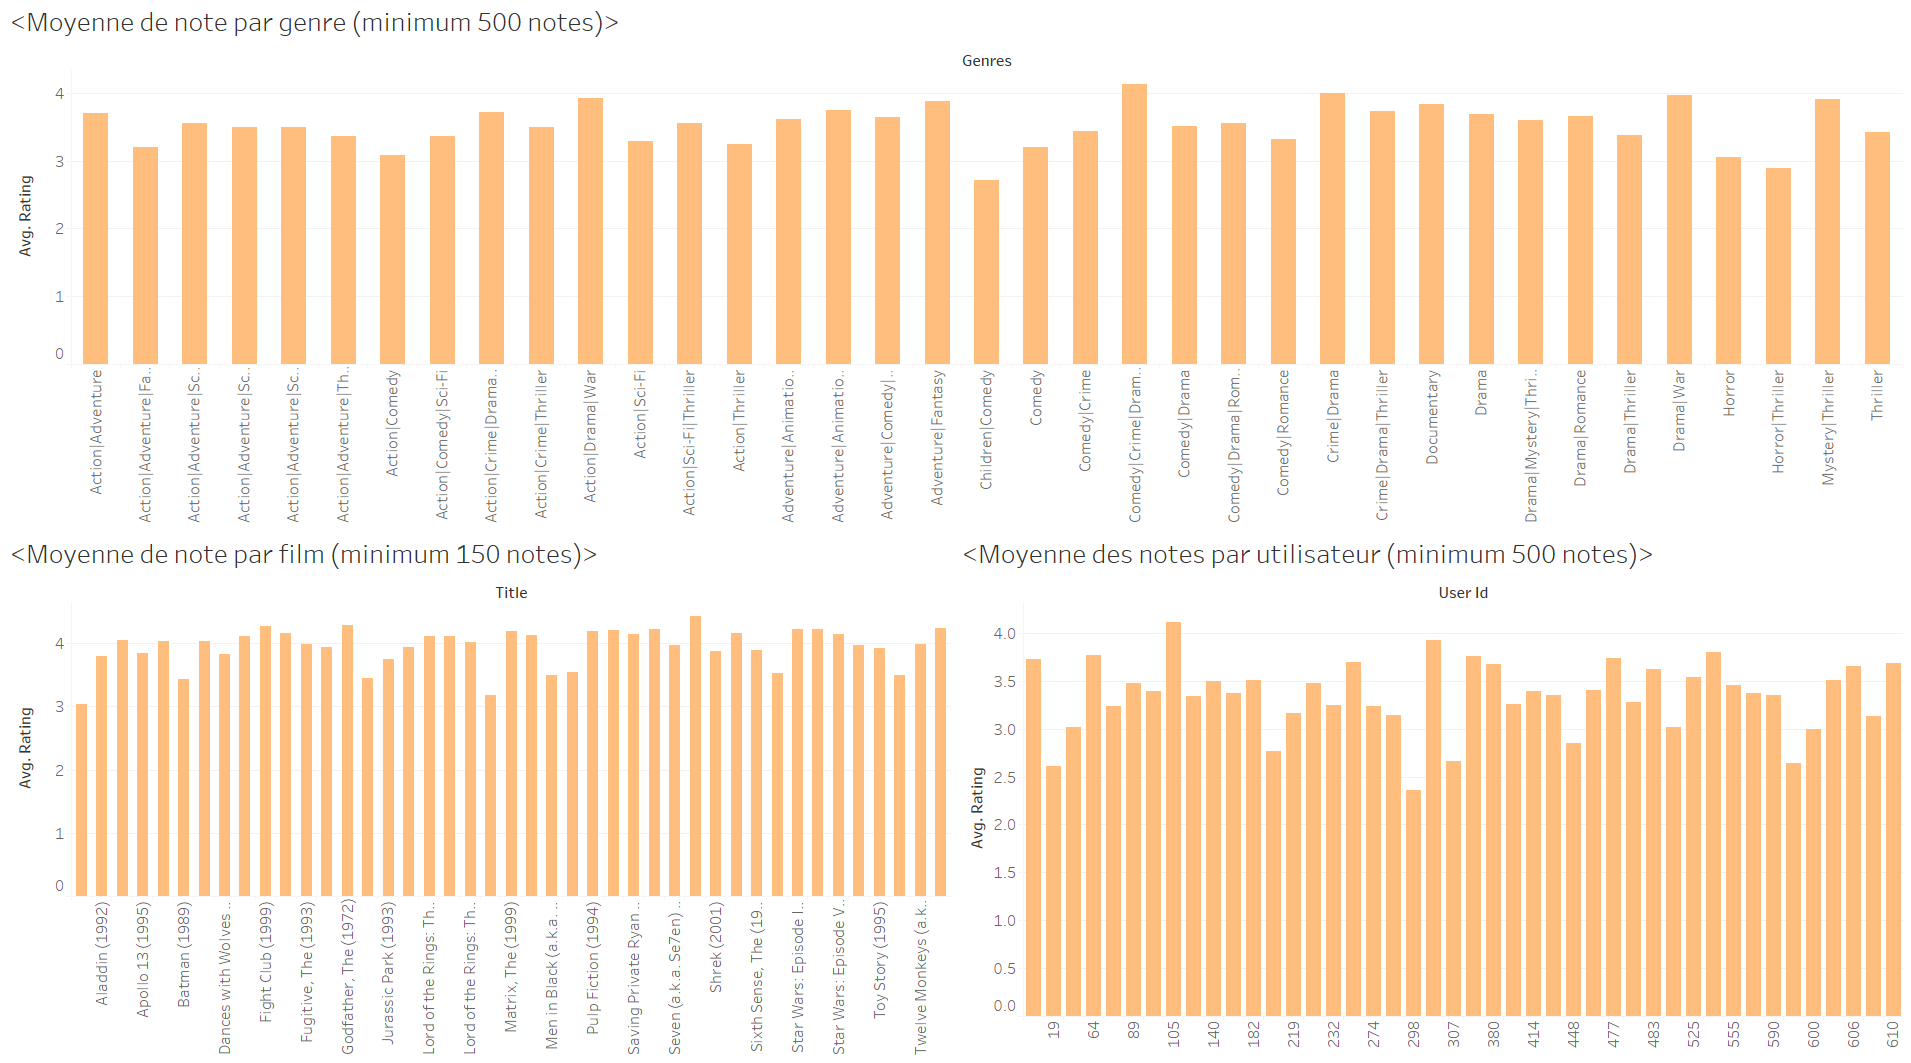

## Modelisation avec Spark MLlib : ALS

In [43]:
# S'assurer que les colonnes ont le bon type
ratings = ratings.withColumn("userId", col("userId").cast("integer")) \
                 .withColumn("movieId", col("movieId").cast("integer")) \
                 .withColumn("rating", col("rating").cast("float"))

# Diviser en 80% training et 20% test
(training, test) = ratings.randomSplit([0.8, 0.2])

In [44]:
from pyspark.ml.recommendation import ALS

als = ALS(
    maxIter=15,           # Nombre d'itérations
    regParam=0.095,         # Paramètre de régularisation
    rank=10,              # Dimension des facteurs latents
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating",
    coldStartStrategy="drop"  # Pour ignorer les prédictions NaN lors de l'évaluation
)

# Entraîner le modèle sur le jeu de données d'entraînement
model = als.fit(training)

In [45]:
from pyspark.ml.evaluation import RegressionEvaluator

# Générer des prédictions sur le test set
predictions = model.transform(test)

# Configurer l'évaluateur RMSE
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = {}".format(rmse))


Root-mean-square error = 0.8861324927845382


In [46]:
# Utilisation d'autres métriques d'évaluation
evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print("Mean absolute error = {}".format(mae))

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print("R² = {}".format(r2))

Mean absolute error = 0.6805386662244048
R² = 0.2739952629214628


In [47]:
# Générer des recommandations pour tous les utilisateurs
userRecs = model.recommendForAllUsers(10)
userRecs.show(10, False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                    |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{33649, 5.714268}, {27611, 5.7107644}, {177593, 5.677044}, {5915, 5.655122}, {5490, 5.647462}, {27523, 5.6348906}, {170355, 5.6147633}, {3379, 5.6147633}, {93988, 5.5755625}, {3925, 5.5534377}] |
|2     |[{6818, 4.9566927}, {131724, 4.907677}, {671, 4.768399}, {7025, 4.69756}, {112421, 4.6819925}, {2693, 4.643266}, {148881, 4.6361175}, {97866, 4.6129994}, {95441, 4.607368},

In [48]:
# Générer les recommandations pour un utilisateur spécifique
userRecs = model.recommendForUserSubset(ratings.filter(col("userId") == 123), 5)
userRecs = userRecs.withColumn("rec", explode(col("recommendations"))) \
                   .select(col("userId"), col("rec.movieId"), col("rec.rating")) \
                   .join(movies, "movieId", "left") \
                   .select("userId", "title", "rating")

userRecs.show(truncate=False)

+------+-----------------------+---------+
|userId|title                  |rating   |
+------+-----------------------+---------+
|123   |Saving Face (2004)     |4.822505 |
|123   |North & South (2004)   |4.7400303|
|123   |De platte jungle (1978)|4.648561 |
|123   |Blue Planet II (2017)  |4.648561 |
|123   |Bitter Lake (2015)     |4.648561 |
+------+-----------------------+---------+



## Recommandation basée sur le contenu

In [52]:
# Charger les données
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

# Exploration des données
movies.head(), ratings.head()

# Traitement des genres
def clean_genres(genres):
    return " ".join(genres.split('|')) if isinstance(genres, str) else ""

movies["clean_genres"] = movies["genres"].apply(clean_genres)

# Création de la matrice TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(movies["clean_genres"])

# Calcul de la similarité cosinus
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Création du mapping des titres vers les index
indices = pd.Series(movies.index, index=movies["title"]).drop_duplicates()

def recommend_movies(title, n=5):
    if title not in indices:
        return ["Film non trouvé. Essayez un autre titre."]
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices]["title"].tolist()

# Interface interactive
output = widgets.Output()
title_dropdown = widgets.Combobox(
    options=movies["title"].tolist(),
    description='Film:',
    ensure_option=True
)

def on_change(change):
    with output:
        output.clear_output(wait=True)
        if change["type"] == "change" and change["name"] == "value":
            recommendations = recommend_movies(change["new"])
            print(f"\nFilms similaires à '{change['new']}':")
            for rec in recommendations:
                print(f"- {rec}")

title_dropdown.observe(on_change, names='value')
display(title_dropdown, output)

Combobox(value='', description='Film:', ensure_option=True, options=('Toy Story (1995)', 'Jumanji (1995)', 'Gr…

Output()

## Recommandation basée sur les proximités utilisateurs (KNN)

In [ ]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors


# Initialisation de Spark
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

# Charger les données
df = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)

# Transformer les genres en liste de genres
def split_genres(genres_str):
    return genres_str.split('|') if genres_str else []

# Enregistrer la fonction en tant que UDF pour PySpark
split_genres_udf = udf(split_genres, ArrayType(StringType()))
df = df.withColumn("genres", split_genres_udf(df["genres"]))

# Convertir le DataFrame PySpark en DataFrame Pandas
df_pandas = df.select("title", "genres").toPandas()

# Utilisation de MultiLabelBinarizer de sklearn pour encoder les genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_pandas["genres"])
X = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Initialisation du modèle KNN de sklearn
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X)

# Fonction de recommandation
def recommend_movies(movie_title):
    # Trouver l'index du film par titre
    idx = df_pandas[df_pandas["title"] == movie_title].index[0]
    # Obtenir les indices des films les plus similaires
    distances, indices = knn.kneighbors([X.iloc[idx]])
    # Extraire les titres des films recommandés
    recommendations = df_pandas.iloc[indices[0][1:]]["title"].values
    return recommendations

# Exemple de recommandation
movie_example = "Toy Story (1995)"
recommended_movies = recommend_movies(movie_example)
print(f"Films similaires à '{movie_example}': {recommended_movies}")


Py4JJavaError: An error occurred while calling o277.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 26.0 failed 1 times, most recent failure: Lost task 0.0 in stage 26.0 (TID 26) (DESKTOP-T7G75U1.lan executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 27 more


## Evaluation des approches de recommandation

In [6]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors

# ✅ Initialisation de Spark
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

# ✅ Charger les données
movies_df = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)
ratings_df = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)

# ✅ Transformer les genres en liste
def split_genres(genres_str):
    return genres_str.split('|') if genres_str else []

split_genres_udf = udf(split_genres, ArrayType(StringType()))
movies_df = movies_df.withColumn("genres", split_genres_udf(movies_df["genres"]))

# ✅ Convertir en DataFrame Pandas
movies_pandas = movies_df.select("movieId", "title", "genres").toPandas()
ratings_pandas = ratings_df.select("userId", "movieId", "rating").toPandas()

# ✅ Vérification des données
print(f"Nombre total de films : {len(movies_pandas)}")
print(f"Nombre total de notes : {len(ratings_pandas)}")

# ✅ Vérifier s’il y a des films bien notés
high_ratings = ratings_pandas[ratings_pandas["rating"] >= 4]
print(f"Nombre total de notes >= 4 : {len(high_ratings)}")

if high_ratings.empty:
    print("Aucun film n'a été noté ≥ 4. Impossible d'évaluer la précision.")
    exit()

# ✅ Encoder les genres avec MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies_pandas["genres"])
X = pd.DataFrame(genres_encoded, columns=mlb.classes_)
X.index = movies_pandas["movieId"]

# ✅ Initialisation du modèle KNN
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X)

# ✅ Fonction de recommandation
def recommend_movies(movie_id, num_recommendations=5):
    if movie_id not in X.index:
        return []
    idx = X.index.get_loc(movie_id)
    distances, indices = knn.kneighbors([X.iloc[idx]], n_neighbors=num_recommendations + 1)
    recommended_ids = X.index[indices[0][1:]]  # Exclure le film de référence
    return movies_pandas[movies_pandas["movieId"].isin(recommended_ids)]["title"].tolist()

# ✅ Évaluation de la Précision@K
def precision_at_k(user_id, k=5):
    user_ratings = ratings_pandas[ratings_pandas["userId"] == user_id]
    liked_movies = user_ratings[user_ratings["rating"] >= 4]["movieId"].tolist()
    
    if not liked_movies:
        return None  # Pas assez de données pour cet utilisateur
    
    recommended = []
    for movie_id in liked_movies:
        recommended.extend(recommend_movies(movie_id, num_recommendations=k))

    recommended = list(set(recommended))  # Supprimer les doublons
    hits = sum(1 for movie in recommended[:k] if movie in liked_movies)
    return hits / k if recommended else 0

# ✅ Évaluation de la Couverture des Recommandations
def item_coverage():
    recommended_movies = set()
    for movie_id in X.index:
        recommended_movies.update(recommend_movies(movie_id, num_recommendations=5))
    
    return len(recommended_movies) / len(X.index)

# ✅ Sélection d'un utilisateur ayant noté des films ≥ 4
users_with_ratings = high_ratings["userId"].unique()
user_test = np.random.choice(users_with_ratings)

# ✅ Affichage des métriques
precision = precision_at_k(user_test, k=5)
coverage = item_coverage()

print(f"\n📊 **Évaluation du modèle**")
print(f"Utilisateur testé : {user_test}")
print(f"Précision@5 pour l'utilisateur {user_test}: {precision:.2%}" if precision is not None else "Pas assez de films notés pour cet utilisateur.")
print(f"Couverture des recommandations: {coverage:.2%}")

# ✅ Génération d'utilisateurs fictifs
fake_users = {
    "Alice": ["Toy Story (1995)", "Finding Nemo (2003)"],
    "Bob": ["The Matrix (1999)", "Inception (2010)"],
    "Charlie": ["Titanic (1997)", "The Notebook (2004)"],
    "David": ["The Godfather (1972)", "Goodfellas (1990)"],
    "Eve": ["The Conjuring (2013)", "Get Out (2017)"]
}

# ✅ Génération des recommandations pour chaque utilisateur fictif
for user, liked_movies in fake_users.items():
    recommended_movies = set()
    
    print(f"\n🎬 **Recommandations pour {user}** (Aime : {', '.join(liked_movies)})")
    
    for movie in liked_movies:
        # Trouver l'ID du film
        movie_row = movies_pandas[movies_pandas["title"] == movie]
        if not movie_row.empty:
            movie_id = movie_row["movieId"].values[0]
            recommended_movies.update(recommend_movies(movie_id, num_recommendations=3))

    # Afficher les recommandations uniques
    print(f"📌 Suggestions : {', '.join(recommended_movies) if recommended_movies else 'Aucune recommandation trouvée'}")



Py4JJavaError: An error occurred while calling o243.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 23.0 failed 1 times, most recent failure: Lost task 0.0 in stage 23.0 (TID 23) (DESKTOP-T7G75U1.lan executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 27 more
